# Scouting Report: China, Italy, Peru, and Chile

**Goal:** To analyze the yield and climate data for our four candidate regions to decide on the best focus for our main analysis.

--- Loading and processing average yield data ---
Processed: maize
Processed: rice
Processed: wheat
Processed: soybean


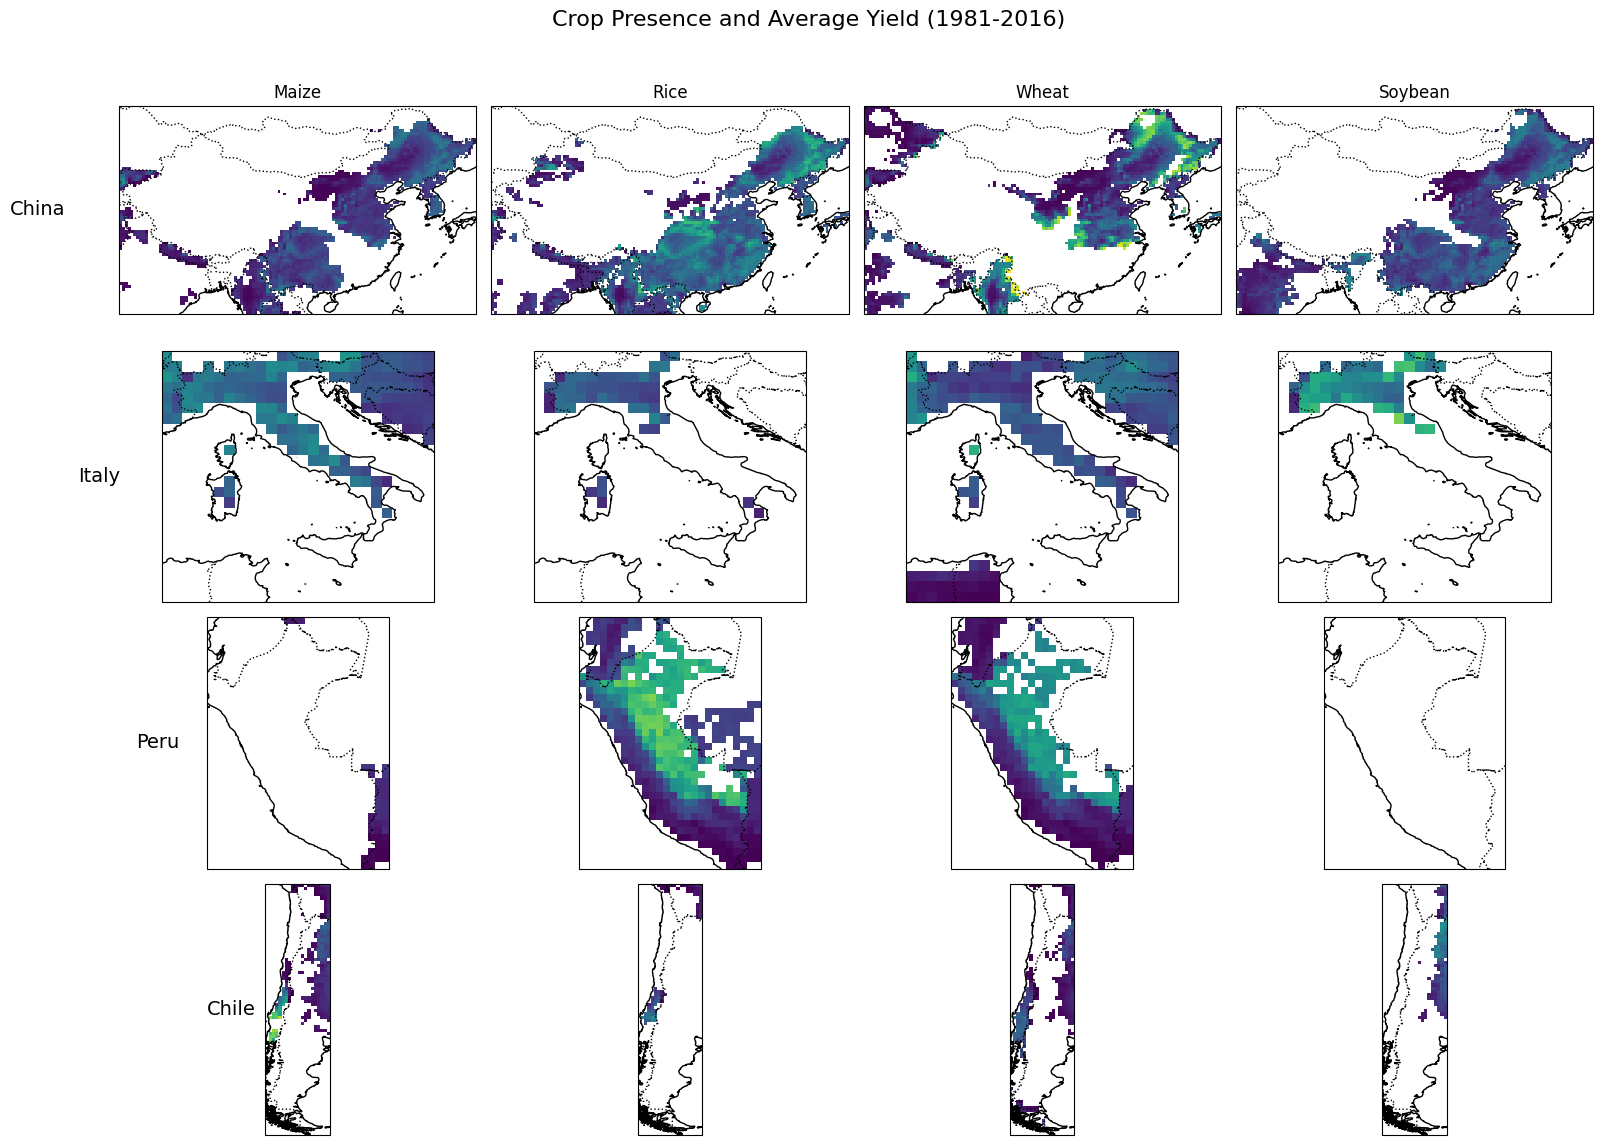

In [10]:
# Cell 1: Crop Presence Dashboard (Corrected Bounding Boxes)
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import glob
import re

# --- Define Bounding Boxes with CORRECTED Longitudes [0 to 360] ---
regions = {
    'China': {'lon': slice(73, 135), 'lat': slice(18, 54)},
    'Italy': {'lon': slice(6, 19), 'lat': slice(35, 47)},
    # CORRECTED: Peru's longitude from [-81, -68] to [279, 292]
    'Peru': {'lon': slice(279, 292), 'lat': slice(-18, 0)},
    # CORRECTED: Chile's longitude from [-74, -64] to [286, 296]
    'Chile': {'lon': slice(286, 296), 'lat': slice(-56, -17)}
}

# --- Load all average yield data ---
CROPS = ['maize', 'rice', 'wheat', 'soybean']
avg_yields = {}
print("--- Loading and processing average yield data ---")

for crop in CROPS:
    data_path = f'../data/{crop}/yield_*.nc4'
    filepaths = sorted(glob.glob(data_path))
    years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
    with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
        ds = ds.assign_coords(time=years)
        avg_yields[crop] = ds['var'].mean(dim='time').compute()
        print(f"Processed: {crop}")

# --- Create the Dashboard Plot ---
fig, axes = plt.subplots(nrows=len(regions), ncols=len(CROPS), figsize=(16, 12), 
                         subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle('Crop Presence and Average Yield (1981-2016)', fontsize=16)

for i, (region_name, bounds) in enumerate(regions.items()):
    for j, crop_name in enumerate(CROPS):
        ax = axes[i, j]
        # Set the map extent using the original [-180, 180] coordinates for cartopy
        original_lon = regions[region_name]['lon']
        lon_start = original_lon.start if original_lon.start > 0 else original_lon.start + 360
        lon_stop = original_lon.stop if original_lon.stop > 0 else original_lon.stop + 360
        
        ax.set_extent([regions[region_name]['lon'].start, regions[region_name]['lon'].stop, 
                       regions[region_name]['lat'].start, regions[region_name]['lat'].stop], 
                      crs=ccrs.PlateCarree(central_longitude=0))

        avg_yields[crop_name].where(avg_yields[crop_name] > 0.1).plot(
            ax=ax, transform=ccrs.PlateCarree(), cmap='viridis', add_colorbar=False
        )
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        if j == 0:
            ax.text(-0.15, 0.5, region_name, va='center', ha='right', fontsize=14, transform=ax.transAxes)
        if i == 0:
            ax.set_title(crop_name.capitalize())

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

## Scouting Question 2: What is the Yield Story?

Now that we know which crops are grown where, let's look at their yield trends and variability over time in each region. This will tell us which systems might be most vulnerable or interesting to study.

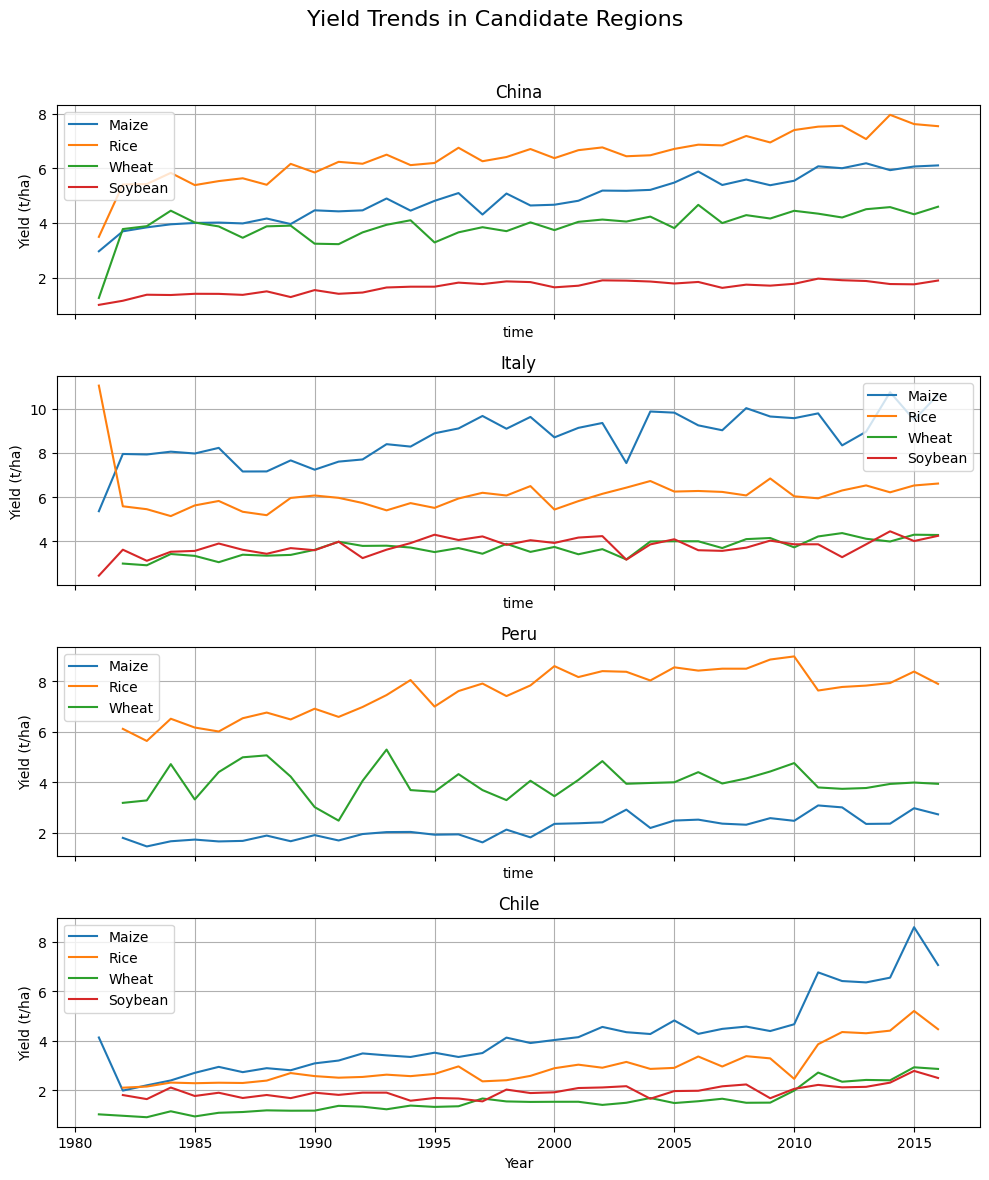

In [11]:
# Cell 2: Regional Yield Time-Series Analysis (Corrected and Improved)
import pandas as pd

# --- Configuration ---
# We will now attempt to plot ALL major crops for each region
CROPS_TO_ANALYZE_ALL = ['maize', 'rice', 'wheat', 'soybean']

# --- Load all full yield datasets (if not already loaded) ---
if 'full_yields' not in locals():
    full_yields = {}
    for crop in CROPS_TO_ANALYZE_ALL:
        data_path = f'../data/{crop}/yield_*.nc4'
        filepaths = sorted(glob.glob(data_path))
        years = [int(re.search(r'(\d{4})\.nc4$', f).group(1)) for f in filepaths]
        with xr.open_mfdataset(data_path, combine='nested', concat_dim='time') as ds:
            ds = ds.assign_coords(time=years)
            full_yields[crop] = ds['var'].compute()
    print("Loaded all crop datasets.")

# --- Create Time-Series Plots ---
fig, axes = plt.subplots(nrows=len(regions), ncols=1, figsize=(10, 12), sharex=True)
fig.suptitle('Yield Trends in Candidate Regions', fontsize=16)

for i, (region_name, bounds) in enumerate(regions.items()):
    ax = axes[i]
    has_data = False # A flag to track if we plot anything for this region
    
    for crop_name in CROPS_TO_ANALYZE_ALL:
        # Select the region from the full dataset
        regional_yield = full_yields[crop_name].sel(**bounds)
        
        # --- CRITICAL CHECK: Does this slice contain any actual data? ---
        # We check if there are any non-NaN values.
        if regional_yield.notnull().any():
            has_data = True # We found data to plot!
            
            # Calculate the weighted average yield for the region over time
            weights = np.cos(np.deg2rad(regional_yield.lat))
            mean_regional_yield = regional_yield.weighted(weights).mean(dim=('lat', 'lon'))
            
            # Plot the time series
            mean_regional_yield.plot(ax=ax, label=crop_name.capitalize())
    
    # --- Improve Plotting ---
    if not has_data:
        ax.text(0.5, 0.5, 'No significant yield data found in this region', 
                ha='center', va='center', transform=ax.transAxes, color='red')

    ax.set_title(region_name)
    ax.set_ylabel('Yield (t/ha)')
    ax.legend()
    ax.grid(True)

plt.xlabel('Year')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Scouting Question 3: What is the Climate Story?

The final step in our scouting report is to see if there is a strong climate signal in our candidate regions. We will load the full 36-year monthly climate dataset and plot the trend of the average growing season temperature for each region. This will show us which regions have experienced the most significant warming.

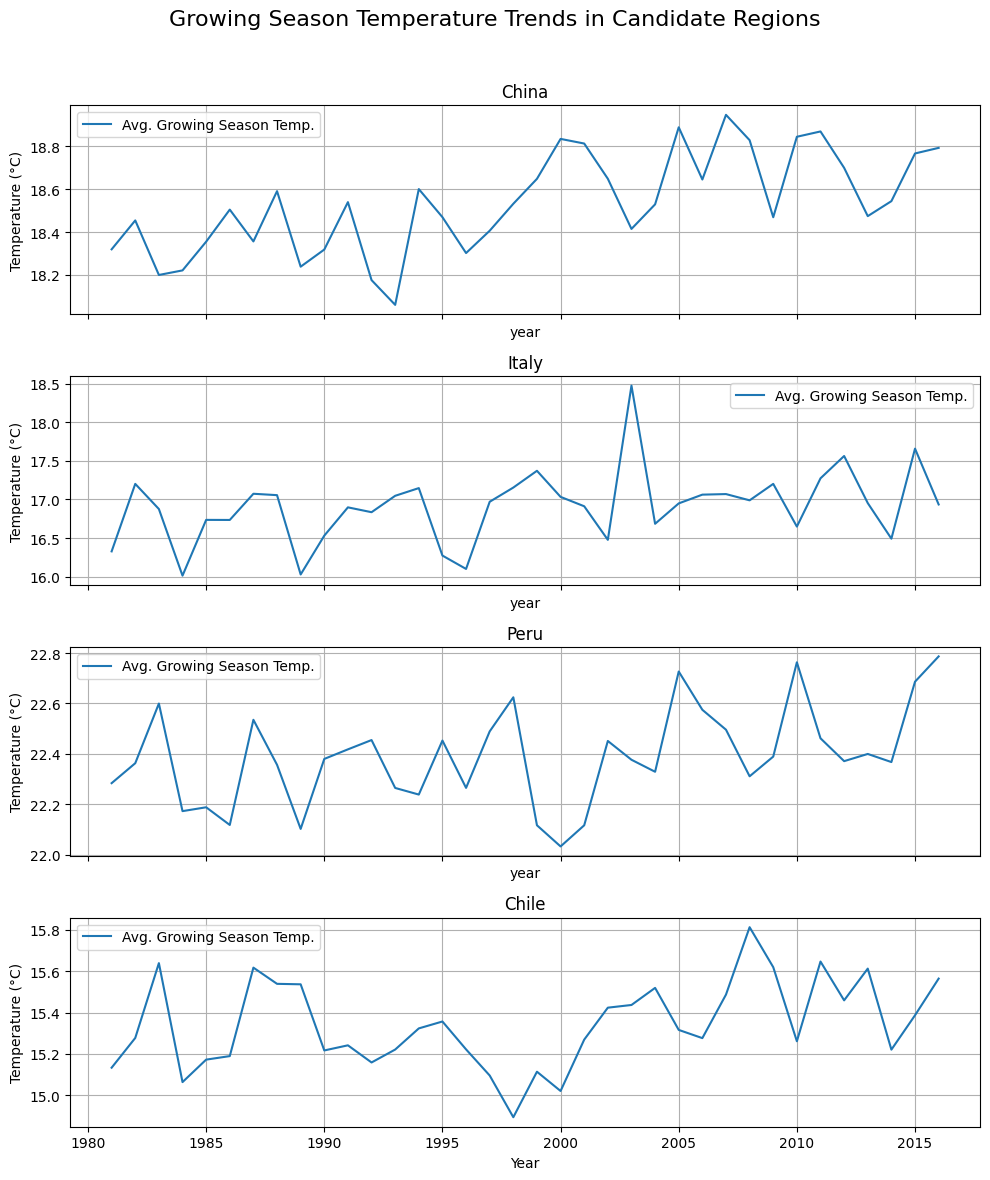

In [14]:
# Cell 3: Regional Climate Trend Analysis (Corrected Averaging Logic)
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 1. Load the full 36-year monthly climate dataset (if not already loaded) ---
if 'ds_climate_full' not in locals():
    print("--- Loading full monthly climate data (1981-2016) ---")
    CLIMATE_PATH = '../data/climate_monthly_full/era5_land_monthly_*.grib'
    ds_climate_full = xr.open_mfdataset(
        CLIMATE_PATH, 
        engine='cfgrib',
        combine='nested',
        concat_dim='time',
        backend_kwargs={'filter_by_keys': {'shortName': '2t'}}
    )
    ds_climate_full = ds_climate_full.assign_coords(time=pd.to_datetime(ds_climate_full.time.values))
    print("Climate data loaded successfully.")

# --- 2. Define the regions dictionary with the correct coordinate names ---
climate_regions = {
    'China': {'longitude': slice(73, 135), 'latitude': slice(54, 18)},
    'Italy': {'longitude': slice(6, 19), 'latitude': slice(47, 35)},
    'Peru': {'longitude': slice(279, 292), 'latitude': slice(0, -18)},
    'Chile': {'longitude': slice(286, 296), 'latitude': slice(-17, -56)}
}

# --- 3. Define the Growing Season Mask (T > 10°C) ---
temp_celsius = ds_climate_full['t2m'] - 273.15
growing_season_mask = temp_celsius > 10

# --- 4. Create the Climate Trend Plots ---
fig, axes = plt.subplots(nrows=len(climate_regions), ncols=1, figsize=(10, 12), sharex=True)
fig.suptitle('Growing Season Temperature Trends in Candidate Regions', fontsize=16)

for i, (region_name, bounds) in enumerate(climate_regions.items()):
    ax = axes[i]
    
    # Select the regional data
    regional_temp = temp_celsius.sel(**bounds)
    regional_mask = growing_season_mask.sel(**bounds)
    
    # Apply the mask to get only growing season temperatures
    seasonal_data = regional_temp.where(regional_mask)
    
    # --- THIS IS THE CORRECTED LOGIC ---
    # 1. Group by year and average over the months in the season (dim='time')
    # 2. Then, average over the spatial dimensions to get ONE number per year
    yearly_avg_temp = seasonal_data.groupby('time.year').mean(dim='time').mean(dim=['latitude', 'longitude'])
    
    # Plot the time series
    yearly_avg_temp.plot(ax=ax, label=f'Avg. Growing Season Temp.')
    
    ax.set_title(region_name)
    ax.set_ylabel('Temperature (°C)')
    ax.legend()
    ax.grid(True)

plt.xlabel('Year')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## Final Analysis: Plotting Yield Anomaly vs. Temperature

We now have all the pieces to make our decision. This final step will create a dashboard of scatter plots, showing the relationship between the de-trended **yield anomaly** and the **average growing season temperature** for each crop in each candidate region.

The slope of the line in these plots is a preliminary vulnerability curve. A steep negative slope suggests high vulnerability to warming.

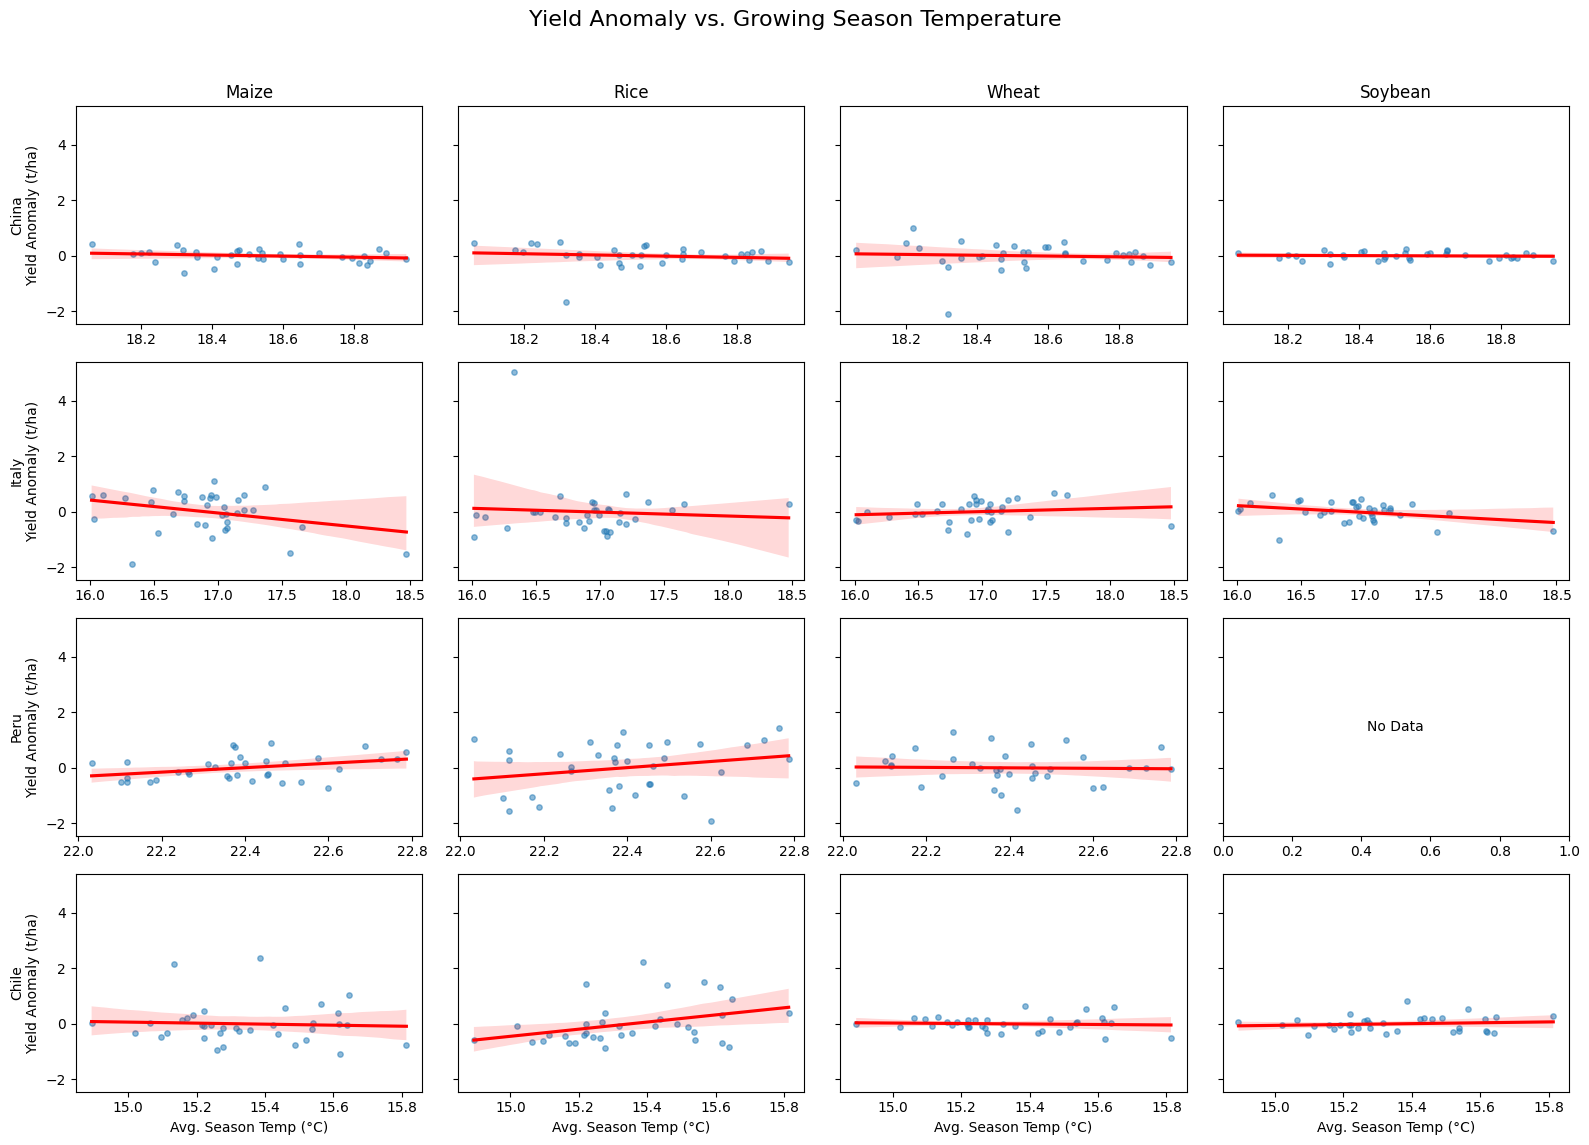

In [16]:
# Cell 4: Yield Anomaly vs. Temperature Scatter Plot Dashboard (Corrected for NaNs)
import pandas as pd
import seaborn as sns
from scipy.signal import detrend

# --- Create the Dashboard Plot ---
fig, axes = plt.subplots(nrows=len(regions), ncols=len(CROPS), figsize=(16, 12), sharey=True)
fig.suptitle('Yield Anomaly vs. Growing Season Temperature', fontsize=16)

for i, (region_name, bounds) in enumerate(regions.items()):
    climate_bounds = climate_regions[region_name]
    
    for j, crop_name in enumerate(CROPS):
        ax = axes[i, j]
        
        regional_yield = full_yields[crop_name].sel(**bounds)
        
        if regional_yield.notnull().any():
            weights = np.cos(np.deg2rad(regional_yield.lat))
            yield_ts = regional_yield.weighted(weights).mean(dim=('lat', 'lon'))
            
            # --- THIS IS THE CORRECTED LOGIC ---
            # Check if the calculated time series has any missing values
            if yield_ts.isnull().any():
                # If yes, use the simpler anomaly method (subtract the mean)
                yield_anomaly = yield_ts - yield_ts.mean()
            else:
                # If no, use the more sophisticated detrend method
                yield_anomaly = detrend(yield_ts.values)

            # The rest of the code is the same
            regional_temp = temp_celsius.sel(**climate_bounds)
            regional_mask = growing_season_mask.sel(**climate_bounds)
            seasonal_data = regional_temp.where(regional_mask)
            yearly_stressor = seasonal_data.groupby('time.year').mean(dim='time').mean(dim=['latitude', 'longitude'])

            df = pd.DataFrame({
                'temperature': yearly_stressor.values,
                'yield_anomaly': yield_anomaly
            }).dropna() # Drop rows where either value might be NaN
            
            if not df.empty:
                sns.regplot(data=df, x='temperature', y='yield_anomaly', ax=ax,
                            scatter_kws={'alpha': 0.5, 's': 15},
                            line_kws={'color': 'red'})
            else:
                ax.text(0.5, 0.5, 'Insufficient Data', ha='center', va='center', transform=ax.transAxes)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)

        # --- Formatting ---
        if j == 0:
            ax.set_ylabel(f"{region_name}\nYield Anomaly (t/ha)")
        else:
            ax.set_ylabel('')
        if i == 0:
            ax.set_title(crop_name.capitalize())
        if i == len(regions) - 1:
            ax.set_xlabel("Avg. Season Temp (°C)")
        else:
            ax.set_xlabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()